In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from PIL import Image
from dataset import *
from save_load import *
from NN_library.AutoUnet.AutoUnet import *
from NN_library.AutoUnet.train_AutoUnet import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Test U-Net

In [63]:
data = dataset_nonuniform()
loaders = get_loaders(data, 1)

In [64]:
name = 'NN_library/AutoUnet/AutoUnet'
#name = 'NN_library/AutoUnet/AutoUnet_pretrained'
args = {'lr' : 0.001, 'epochs' : 20, 'dev' : dev, 'name' : name}
unet = AutoUNet()
unet = load_network(unet, args['name'], args)

In [65]:
L_dam, L_dam_total = test(unet, loaders, args)
L_dam = np.array(L_dam)
L_dam_total = np.array(L_dam_total)

In [66]:
Var, Var_true = test_blur(unet, loaders, args)
Var = np.array(Var)
Var_true = np.array(Var_true)

In [69]:
dam_mean = L_dam.mean()
dam_std = L_dam.std()
print('Mean damage:', dam_mean)
print('Std damage:', dam_std)

Mean damage: 0.025280666
Std damage: 0.025516951


In [70]:
dam_mean = np.mean(L_dam, axis=0)
dam_std = np.std(L_dam, axis=0)
dam_mean_total = np.mean(L_dam_total, axis=0)
dam_std_total = np.std(L_dam_total, axis=0)
print('Final mean damage:', dam_mean[-1])
print('Final std damage:', dam_std[-1])

Final mean damage: 0.07768425
Final std damage: 0.021666117


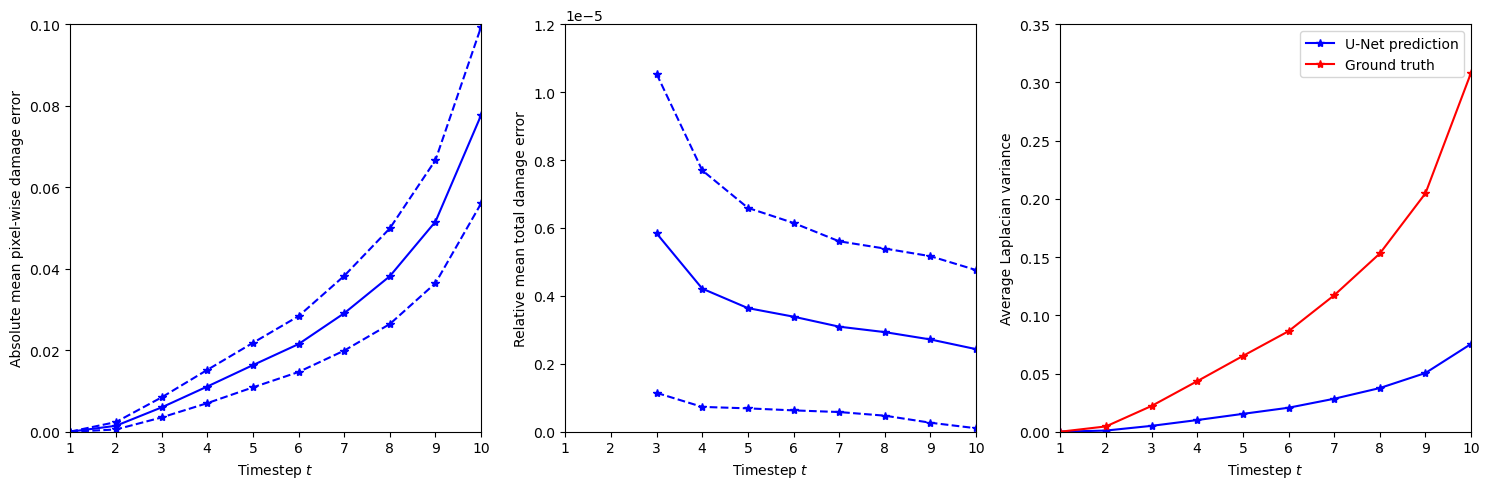

In [71]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=100)

axs[0].plot(np.arange(1, 11), dam_mean, 'b-*')
axs[0].plot(np.arange(1, 11), dam_mean+dam_std, 'b--*')
axs[0].plot(np.arange(1, 11), dam_mean-dam_std, 'b--*')
axs[0].set_xlabel('Timestep $t$')
axs[0].set_ylabel('Absolute mean pixel-wise damage error')
axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 0.1])

axs[1].plot(np.arange(1, 11), dam_mean_total / (99 * 99), 'b-*')
axs[1].plot(np.arange(1, 11), (dam_mean_total+dam_std_total) / (99 * 99), 'b--*')
axs[1].plot(np.arange(1, 11), (dam_mean_total-dam_std_total) / (99 * 99), 'b--*')
axs[1].set_xlabel('Timestep $t$')
axs[1].set_ylabel('Relative mean total damage error')
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0, 1.2e-5])

axs[2].plot(np.arange(1, 11), Var.mean(axis=0), 'b-*')
axs[2].plot(np.arange(1, 11), Var_true.mean(axis=0), 'r-*')
axs[2].legend(['U-Net prediction', 'Ground truth'])
axs[2].set_xlabel('Timestep $t$')
axs[2].set_ylabel('Average Laplacian variance')
axs[2].set_xlim([1, 10])
axs[2].set_ylim([0, 0.35])

plt.tight_layout()

In [52]:
from NN_library.ConvNet.ConvNet import *
from NN_library.ConvNet.train_ConvNet import *

name = 'NN_library/ConvNet/ConvNet'
args = {'lr' : 0.001, 'epochs' : 20, 'dev' : dev, 'name' : name}
net = ConvNet(16)
net = load_network(net, args['name'], args)

L_stiff_ex, L_shr_ex = test_Conv(net, loaders, args)
L_shr_ex = np.array(L_shr_ex)
L_stiff_ex = np.array(L_stiff_ex)

L_stiff, L_shr = test_w_Auto(unet, net, loaders, args)
L_shr = np.array(L_shr)
L_stiff = np.array(L_stiff)

Using device: cuda


In [54]:
shr_mean_ex = np.mean(L_shr_ex, axis=0)
shr_std_ex = np.std(L_shr_ex, axis=0)
stiff_mean_ex = np.mean(L_stiff_ex, axis=0)
stiff_std_ex = np.std(L_stiff_ex, axis=0)

shr_mean = np.mean(L_shr, axis=0)
shr_std = np.std(L_shr, axis=0)
stiff_mean = np.mean(L_stiff, axis=0)
stiff_std = np.std(L_stiff, axis=0)

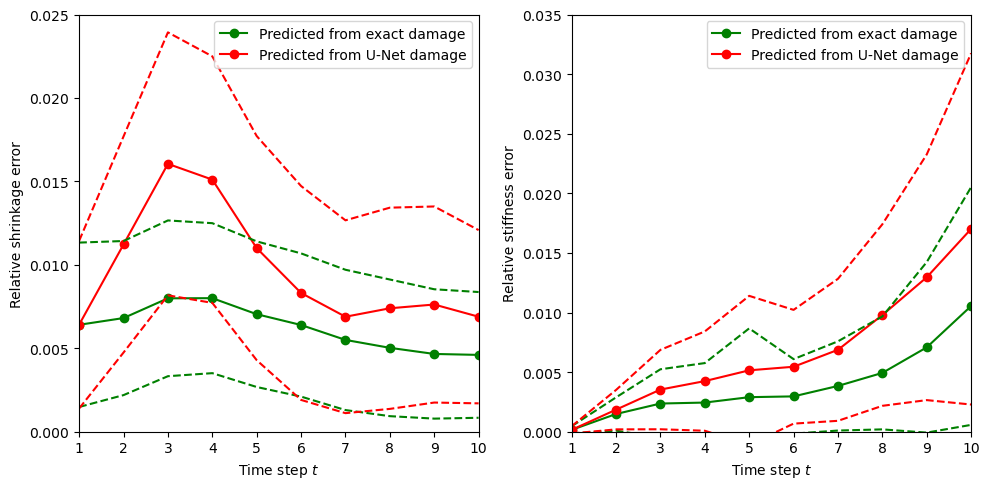

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)

axs.flat[0].plot(np.arange(1, 11), shr_mean_ex, 'g-o')
axs.flat[0].plot(np.arange(1, 11), shr_mean, 'r-o')
axs.flat[0].plot(np.arange(1, 11), shr_mean_ex+shr_std_ex, 'g--')
axs.flat[0].plot(np.arange(1, 11), shr_mean_ex-shr_std_ex, 'g--')
axs.flat[0].plot(np.arange(1, 11), shr_mean+shr_std, 'r--')
axs.flat[0].plot(np.arange(1, 11), shr_mean-shr_std, 'r--')
axs.flat[0].legend(['Predicted from exact damage', 'Predicted from U-Net damage'])
axs.flat[0].set_xlabel('Time step $t$')
axs.flat[0].set_ylabel('Relative shrinkage error')
axs.flat[0].set_xlim([1, 10])
axs.flat[0].set_ylim([0, 0.025])

axs.flat[1].plot(np.arange(1, 11), stiff_mean_ex, 'g-o')
axs.flat[1].plot(np.arange(1, 11), stiff_mean, 'r-o')
axs.flat[1].plot(np.arange(1, 11), stiff_mean_ex+stiff_std_ex, 'g--')
axs.flat[1].plot(np.arange(1, 11), stiff_mean_ex-stiff_std_ex, 'g--')
axs.flat[1].plot(np.arange(1, 11), stiff_mean+stiff_std, 'r--')
axs.flat[1].plot(np.arange(1, 11), stiff_mean-stiff_std, 'r--')
axs.flat[1].legend(['Predicted from exact damage', 'Predicted from U-Net damage'])
axs.flat[1].set_xlabel('Time step $t$')
axs.flat[1].set_ylabel('Relative stiffness error')
axs.flat[1].set_xlim([1, 10])
axs.flat[1].set_ylim([0, 0.035])

plt.tight_layout()

In [59]:
seq_test_dam = []
seq_test_stf = []
seq_test_shr = []
geometry, damage, imp_shrinkage, obs_shrinkage, stiffness = data.__getitem__(0)
geometry = geometry.to(args['dev'])
damage = damage.to(args['dev'])
imp_shrinkage = imp_shrinkage.to(args['dev'])
for n in range(10):
    if n == 0:
        x = torch.cat([geometry, imp_shrinkage[[n+1]] / -0.001, damage[[n],:,:]], axis=1).view(1,3,99,99)
    else:
        x = torch.cat([geometry, imp_shrinkage[[n+1]] / -0.001, y[0].detach()], axis=1).view(1,3,99,99)
    y = unet(x)
    x_shr = torch.cat([geometry, imp_shrinkage[[n+1]] / -0.001, y[0].detach()], axis=1).view(1,3,99,99)
    y_shr = net(x_shr)
    seq_test_dam.append(y.detach().cpu())
    seq_test_stf.append(y_shr[0, 0].detach().cpu())
    seq_test_shr.append(y_shr[0, 1].detach().cpu())

seq_test_dam = np.array(seq_test_dam).squeeze()
seq_test_stf = np.array(seq_test_stf)
seq_test_shr = np.array(seq_test_shr)

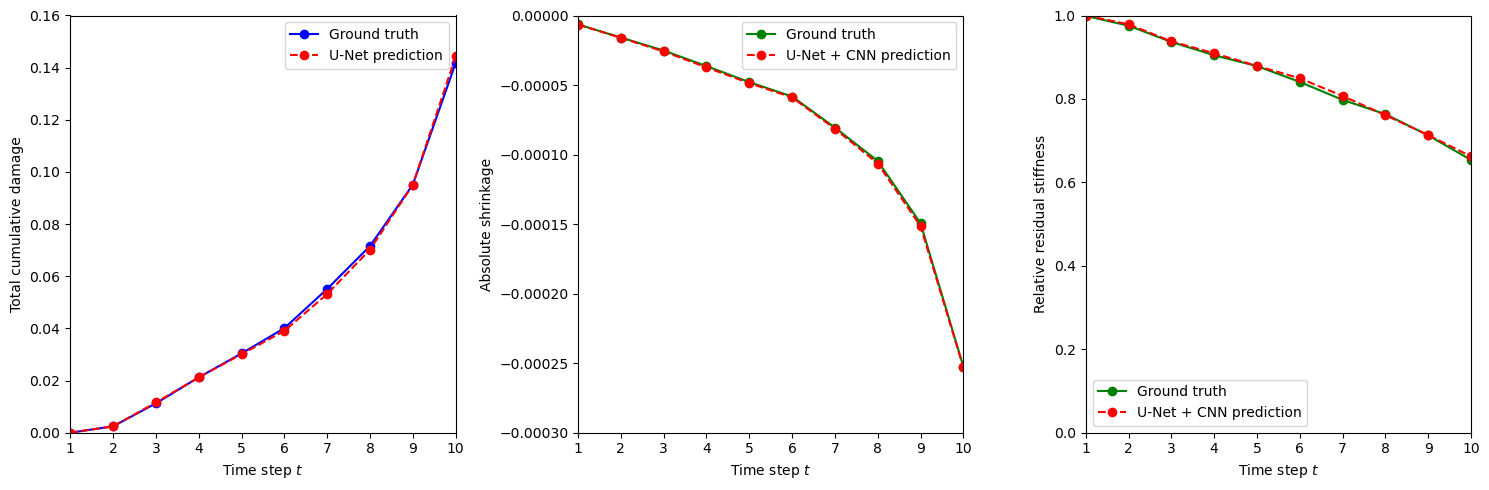

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=100)

axs.flat[0].plot(np.arange(1, 11), (damage[1:].sum(dim=(1, 2)) / (99 * 99)).cpu().detach(), 'b-o')
axs.flat[0].plot(np.arange(1, 11), seq_test_dam.sum(axis=(1, 2)) / (99 * 99), 'r--o')
axs.flat[0].legend(['Ground truth', 'U-Net prediction'])
axs.flat[0].set_xlabel('Time step $t$')
axs.flat[0].set_ylabel('Total cumulative damage')
axs.flat[0].set_xlim([1, 10])
axs.flat[0].set_ylim([0, 0.16])

axs.flat[1].plot(np.arange(1, 11), obs_shrinkage[1:], 'g-o')
axs.flat[1].plot(np.arange(1, 11), seq_test_shr * (-0.001), 'r--o')
axs.flat[1].legend(['Ground truth', 'U-Net + CNN prediction'])
axs.flat[1].set_xlabel('Time step $t$')
axs.flat[1].set_ylabel('Absolute shrinkage')
axs.flat[1].set_xlim([1, 10])
axs.flat[1].set_ylim([-0.0003, 0])

axs.flat[2].plot(np.arange(1, 11), stiffness[1:] / stiffness[0], 'g-o')
axs.flat[2].plot(np.arange(1, 11), seq_test_stf, 'r--o')
axs.flat[2].legend(['Ground truth', 'U-Net + CNN prediction'])
axs.flat[2].set_xlabel('Time step $t$')
axs.flat[2].set_ylabel('Relative residual stiffness')
axs.flat[2].set_xlim([1, 10])
axs.flat[2].set_ylim([0, 1])

plt.tight_layout()

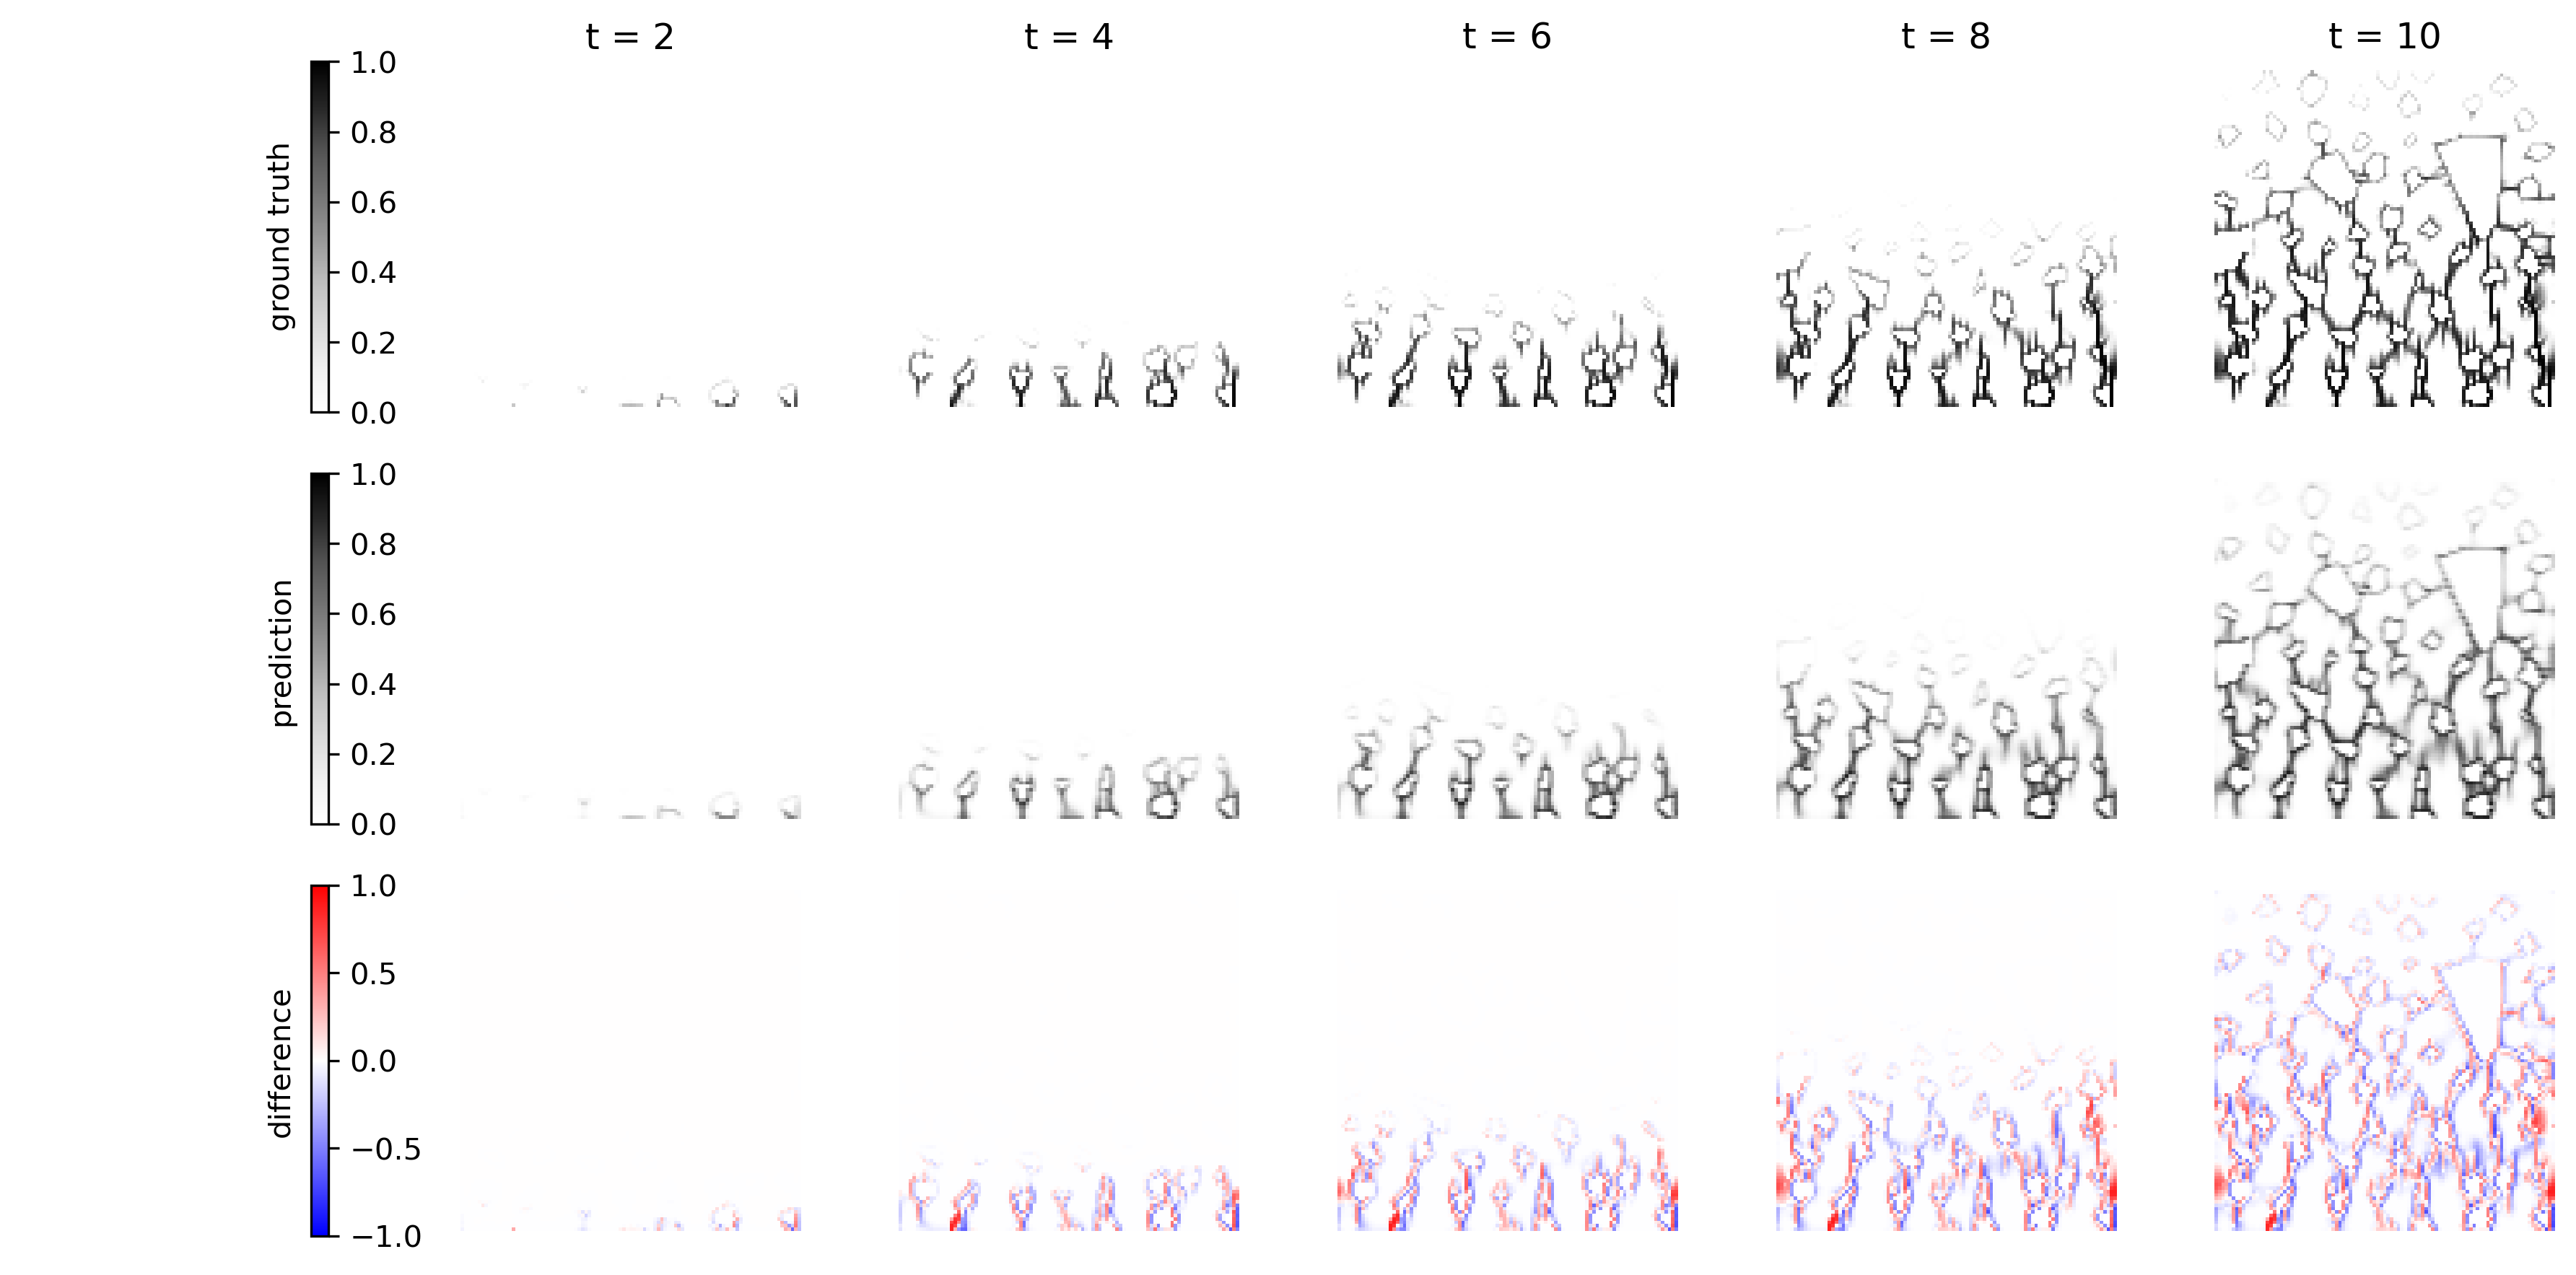

In [61]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(12, 6), dpi=300)
for j in range(5):
    axs[0, j+1].imshow(damage[2*j+2].cpu().detach().numpy(), cmap='Greys', vmin=0, vmax=1)
    axs[0, j+1].set_title(f't = {2*j+2}')
    axs[0, j+1].set_axis_off()
    pos1 = axs[1, j+1].imshow(seq_test_dam[2*j+1], cmap='Greys', vmin=0, vmax=1)
    axs[1, j+1].set_axis_off()
    pos2 = axs[2, j+1].imshow((damage[2*j+2].cpu()-seq_test_dam[2*j+1]).detach().numpy(), cmap='bwr', vmin=-1, vmax=1)
    axs[2, j+1].set_axis_off()
axs[0,0].text(0.9, 0.25, 'ground truth', rotation='vertical')
axs[0,0].set_axis_off()
axs[1,0].text(0.9, 0.3, 'prediction', rotation='vertical')
axs[1,0].set_axis_off()
axs[2,0].text(0.9, 0.3, 'difference', rotation='vertical')
axs[2,0].set_axis_off()

fig.colorbar(pos1, ax=axs[0,0])
fig.colorbar(pos1, ax=axs[1,0])
fig.colorbar(pos2, ax=axs[2,0])
plt.tight_layout()